In [ ]:
#%%

# The following environment is selected
# ~/TSA_project/.venv/bin/python

In [ ]:
#%% 

from IPython.display import Markdown, display
display(Markdown("""
# 1. Data Collection and Portfolio Construction  
**Objective:** To create a diversified, equally weighted portfolio comprising five financial instruments across distinct asset classes, and prepare the dataset for volatility modeling.  
Data was collected for the period from 2020-05-01 to 2025-05-01.  

**Instruments chosen:**  
- S&P 500 Index (Equity Index)  
- Apple Inc. (Stock)  
- EUR/USD (Currency Pair)  
- Gold Futures (Commodity)  
- Ethereum (Cryptocurrency)  

All instruments were sourced using Yahoo Finance (`yfinance` package).  
Daily adjusted closing prices were aligned across all instruments.  
The portfolio was constructed with equal weights (20%) and daily log returns were calculated.
"""))


# 1. Data Collection and Portfolio Construction  
**Objective:** To create a diversified, equally weighted portfolio comprising five financial instruments across distinct asset classes, and prepare the dataset for volatility modeling.  
Data was collected for the period from 2020-05-01 to 2025-05-01.  

**Instruments chosen:**  
- S&P 500 Index (Equity Index)  
- Apple Inc. (Stock)  
- EUR/USD (Currency Pair)  
- Gold Futures (Commodity)  
- Ethereum (Cryptocurrency)  

All instruments were sourced using Yahoo Finance (`yfinance` package).  
Daily adjusted closing prices were aligned across all instruments.  
The portfolio was constructed with equal weights (20%) and daily log returns were calculated.


In [ ]:
#%% 

import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, acf, pacf
from statsmodels.tsa.api import VAR
from statsmodels.api import OLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from IPython.display import Markdown
from arch import arch_model
from scipy import stats
from curl_cffi import requests
from scipy.stats import norm
from scipy.optimize import minimize
#from arch.unitroot import arch_unitroot_test
from statsmodels.stats.diagnostic import acorr_ljungbox

In [ ]:
#%%

file_path = "/Users/shah/TSA_project/prices.pkl"
prices=pd.read_pickle(file_path)

In [ ]:
#%%

def adf_test0(series, max_lag=3):
    result = adfuller(series.dropna(), maxlag=max_lag, autolag=None)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

In [ ]:
#%%

######################### ADF TEST WITH  AUGMENTATIONS ###########################################
def adf_test(series, max_aug=10, version='c'):
    
    results = []

    y = series.diff()
    X = pd.DataFrame({'y_lag': series.shift()})

    if version == 'c' or version == 't': # constant to be added optionally 
        X = sm.add_constant(X)
    if version == 't': # (deterministic) trend component to be added optionally
        X['trend'] = range(len(X))

    for i in range(0, max_aug): # iterating through different numbers of augmentations
        
        for aug in range(1, i+1): # adding augmentations max_aug is reached
            X['aug_'+str(aug)] = y.shift(aug)

        model = sm.OLS(series.diff(), X, missing='drop').fit() # fitting a linear regression with OLS

        ts = model.tvalues['y_lag'] # test statistic
        nobs = model.nobs # number of observations

        if version == 'n': # critical values for basic version of ADF
            if nobs > 100:
                cv01 = -2.567; cv05 = -1.941; cv10 = -1.616 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 'c': # critical values for version with constant
            if nobs > 100:
                cv01 = -3.434; cv05 = -2.863; cv10 = -2.568 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 't': # critical values for version with constant and (deterministic) trend component
            if nobs > 100:
                cv01 = -3.963; cv05 = -3.413; cv10 = -3.128 # critical values for more than 500 observations
            else:
                cv01 = np.nan; cv05 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually

        bg_test01 = smd.acorr_breusch_godfrey(model, nlags=1);  bg_pvalue01 = round(bg_test01[1],4); bg_test01 = round(bg_test01[0],4); 
        bg_test05 = smd.acorr_breusch_godfrey(model, nlags=5);  bg_pvalue05 = round(bg_test05[1],4); bg_test05 = round(bg_test05[0],4); 
        bg_test10 = smd.acorr_breusch_godfrey(model, nlags=10); bg_pvalue10 = round(bg_test10[1],4); bg_test10 = round(bg_test10[0],4);
        bg_test15 = smd.acorr_breusch_godfrey(model, nlags=15); bg_pvalue15 = round(bg_test15[1],4); bg_test15 = round(bg_test15[0],4);

        results.append([i, ts, cv01, cv05, cv10, 
                        bg_test01, bg_pvalue01, bg_test05, bg_pvalue05, bg_test10, bg_pvalue10, bg_test15, bg_pvalue15])

    results_df = pd.DataFrame(results)
    results_df.columns = ['number of augmentations', 
                          'ADF test statistic', 'ADF critival value (1%)', 'ADF critival value (5%)', 'ADF critival value (10%)', 
                          'BG test (1 lag) (statistic)', 'BG test (1 lag) (p-value)', 
                          'BG test (5 lags) (statistic)', 'BG test (5 lags) (p-value)', 
                          'BG test (10 lags) (statistic)', 'BG test (10 lags) (p-value)', 
                          'BG test (15 lags) (statistic)', 'BG test (15 lags) (p-value)']
    
    return results_df

In [ ]:
#%%

cols = ['Company_Stock', 'Crypto', 'FX_Pair', 'Commodity', 'Equity_Index']
"""returns = prices[cols].pct_change().add_suffix('_ret')"""
returns = np.log(prices[cols] / prices[cols].shift(1)).add_suffix('_ret')
prices = pd.concat([prices, returns], axis=1).dropna()
print(prices.filter(like='_ret').head())

Ticker      Company_Stock_ret  Crypto_ret  FX_Pair_ret  Commodity_ret  \
Date                                                                    
2020-05-04           0.014050   -0.028625     0.001292       0.007291   
2020-05-05           0.014898   -0.006746    -0.005062      -0.001466   
2020-05-06           0.010264   -0.013235    -0.006044      -0.011923   
2020-05-07           0.010292    0.039557    -0.003700       0.022080   
2020-05-08           0.023523    0.003302     0.003570      -0.006935   

Ticker      Equity_Index_ret  
Date                          
2020-05-04          0.004241  
2020-05-05          0.009000  
2020-05-06         -0.007004  
2020-05-07          0.011439  
2020-05-08          0.016731  


In [ ]:
#%%

def portfolio_return(df):
    assets = ['Company_Stock_ret', 'Crypto_ret', 'FX_Pair_ret', 'Commodity_ret', 'Equity_Index_ret']
    weight = 1 / len(assets)
    df['portfolio'] = df[assets].mul(weight).sum(axis=1)
    return df

print(prices.filter(like='_ret').head())

Ticker      Company_Stock_ret  Crypto_ret  FX_Pair_ret  Commodity_ret  \
Date                                                                    
2020-05-04           0.014050   -0.028625     0.001292       0.007291   
2020-05-05           0.014898   -0.006746    -0.005062      -0.001466   
2020-05-06           0.010264   -0.013235    -0.006044      -0.011923   
2020-05-07           0.010292    0.039557    -0.003700       0.022080   
2020-05-08           0.023523    0.003302     0.003570      -0.006935   

Ticker      Equity_Index_ret  
Date                          
2020-05-04          0.004241  
2020-05-05          0.009000  
2020-05-06         -0.007004  
2020-05-07          0.011439  
2020-05-08          0.016731  


In [ ]:
#%%

# Main cell: splitting into train and test
df = portfolio_return(prices)
df.columns

Index(['Company_Stock', 'Crypto', 'FX_Pair', 'Commodity', 'Equity_Index',
       'Company_Stock_ret', 'Crypto_ret', 'FX_Pair_ret', 'Commodity_ret',
       'Equity_Index_ret', 'portfolio'],
      dtype='object', name='Ticker')

In [ ]:
#%%

train = prices.iloc[:-261]  
test  = prices.iloc[-261:] 

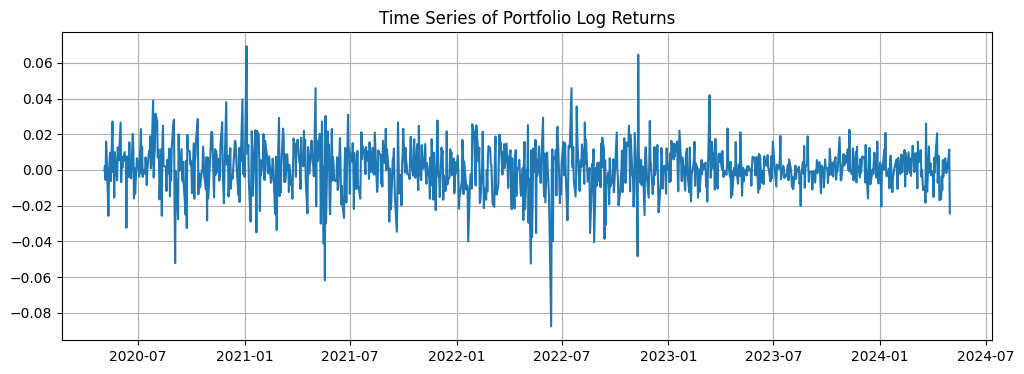

In [ ]:
#%%

# Plot time series of returns
plt.figure(figsize=(12, 4))
plt.plot(train['portfolio'])
plt.title('Time Series of Portfolio Log Returns')
plt.grid(True)
plt.show()

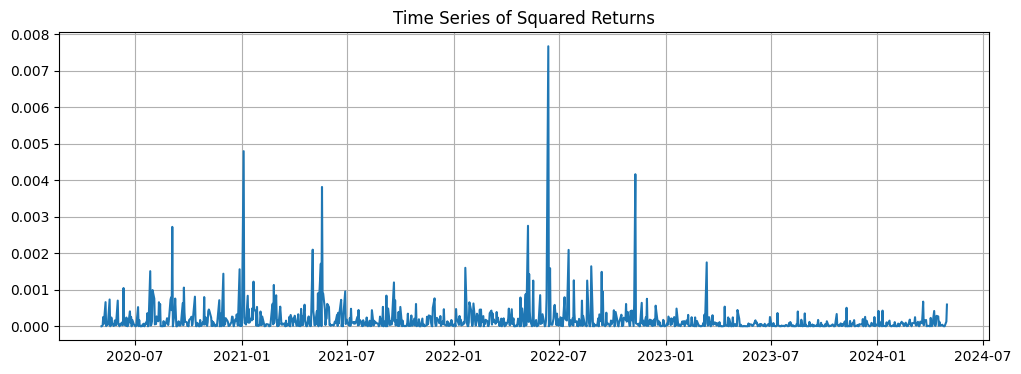

In [ ]:
#%%

# Plot squared returns
plt.figure(figsize=(12, 4))
plt.plot(train['portfolio'] ** 2)
plt.title('Time Series of Squared Returns')
plt.grid(True)
plt.show()

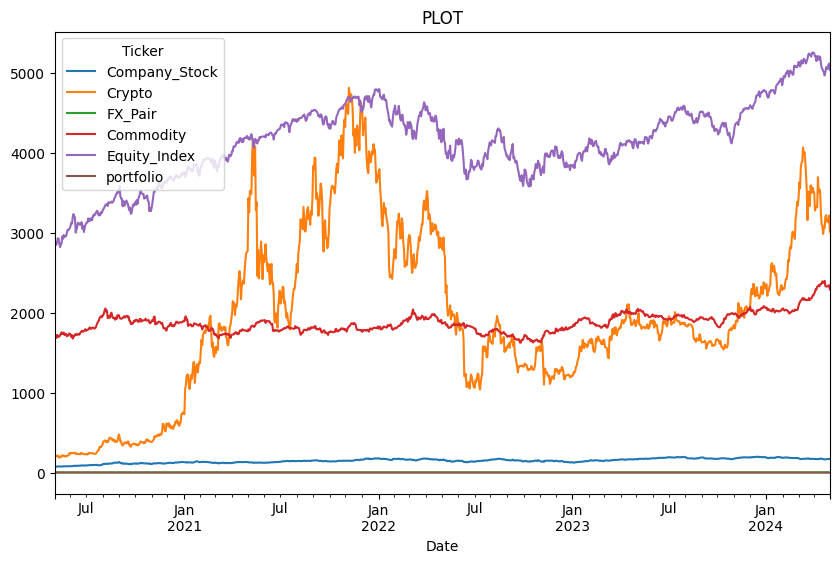

In [ ]:
#%%

################### initial eda ################
train[['Company_Stock', 'Crypto', 'FX_Pair', 'Commodity', 'Equity_Index', 'portfolio']].plot(figsize=(10, 6), title="PLOT")
plt.show()

In [ ]:
#%%

############# ADF TEST ##############
train.columns

adf_test0(train['Company_Stock_ret'])
adf_test0(train['Crypto_ret'])
adf_test0(train['FX_Pair_ret'])
adf_test0(train['Commodity_ret'])
adf_test0(train['Equity_Index_ret'])

ADF Statistic: -16.36576797986547
p-value: 2.8417613594191543e-29
Critical Values: {'1%': np.float64(-3.4366655541494944), '5%': np.float64(-2.8643284548748533), '10%': np.float64(-2.5682546880209087)}
ADF Statistic: -15.842969744781632
p-value: 9.644316672905744e-29
Critical Values: {'1%': np.float64(-3.4366655541494944), '5%': np.float64(-2.8643284548748533), '10%': np.float64(-2.5682546880209087)}
ADF Statistic: -16.26980760682723
p-value: 3.497261610637794e-29
Critical Values: {'1%': np.float64(-3.4366655541494944), '5%': np.float64(-2.8643284548748533), '10%': np.float64(-2.5682546880209087)}
ADF Statistic: -15.965084837314926
p-value: 7.106966336420415e-29
Critical Values: {'1%': np.float64(-3.4366655541494944), '5%': np.float64(-2.8643284548748533), '10%': np.float64(-2.5682546880209087)}
ADF Statistic: -17.08971776154879
p-value: 7.605652155453357e-30
Critical Values: {'1%': np.float64(-3.4366655541494944), '5%': np.float64(-2.8643284548748533), '10%': np.float64(-2.56825468802

In [ ]:
#%% 

adf_test(train['Company_Stock'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-2.646964,-3.434,-2.863,-2.568,0.0964,0.7562,2.4464,0.7845,13.7286,0.1857,18.3427,0.2451
1,1,-2.618171,-3.434,-2.863,-2.568,0.9195,0.3376,2.3543,0.7983,13.5697,0.1935,18.2220,0.2512
2,2,-2.595606,-3.434,-2.863,-2.568,0.5203,0.4707,1.2400,0.9410,12.9152,0.2285,17.3668,0.2974
3,3,-2.575505,-3.434,-2.863,-2.568,0.2156,0.6424,0.9763,0.9645,12.7012,0.2409,17.1128,0.3122
4,4,-2.528049,-3.434,-2.863,-2.568,0.4319,0.5111,2.2629,0.8117,12.6624,0.2432,16.9474,0.3220
5,5,-2.500812,-3.434,-2.863,-2.568,0.1884,0.6643,8.5889,0.1266,12.6373,0.2447,16.9205,0.3236
6,6,-2.534823,-3.434,-2.863,-2.568,0.8478,0.3572,4.4092,0.4921,12.3903,0.2598,16.8553,0.3276
7,7,-2.569098,-3.434,-2.863,-2.568,1.3332,0.2482,9.1700,0.1025,12.1194,0.2771,15.9612,0.3846
8,8,-2.562357,-3.434,-2.863,-2.568,5.6218,0.0177,10.8818,0.0538,14.4946,0.1516,14.9229,0.4570
9,9,-2.595061,-3.434,-2.863,-2.568,3.0212,0.0822,5.7372,0.3326,8.9423,0.5376,9.9393,0.8235


In [ ]:
#%%

adf_test(train['Crypto'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.965069,-3.434,-2.863,-2.568,7.9529,0.0048,15.0211,0.0103,24.9026,0.0055,30.7030,0.0096
1,1,-1.838867,-3.434,-2.863,-2.568,2.7940,0.0946,7.2936,0.1997,16.7931,0.0791,22.9338,0.0856
2,2,-1.912924,-3.434,-2.863,-2.568,0.0399,0.8418,5.1703,0.3955,13.6239,0.1908,20.1368,0.1667
3,3,-1.918057,-3.434,-2.863,-2.568,1.2503,0.2635,6.5669,0.2549,13.7803,0.1833,20.2160,0.1638
4,4,-1.969061,-3.434,-2.863,-2.568,2.8344,0.0923,11.1650,0.0482,13.3423,0.2052,19.0428,0.2118
5,5,-1.901842,-3.434,-2.863,-2.568,0.3302,0.5655,9.7792,0.0817,12.9191,0.2282,16.4068,0.3555
6,6,-1.876903,-3.434,-2.863,-2.568,5.4911,0.0191,8.5734,0.1273,14.6919,0.1437,15.9496,0.3854
7,7,-1.978047,-3.434,-2.863,-2.568,1.6847,0.1943,7.9130,0.1611,9.8997,0.4493,11.6733,0.7036
8,8,-1.917252,-3.434,-2.863,-2.568,0.4209,0.5165,7.5564,0.1824,8.7612,0.5549,14.3154,0.5018
9,9,-1.949384,-3.434,-2.863,-2.568,1.6763,0.1954,7.3346,0.1969,8.4016,0.5897,13.8983,0.5333


In [ ]:
#%%

adf_test(train['FX_Pair'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.230898,-3.434,-2.863,-2.568,0.0652,0.7984,2.2801,0.8092,10.8972,0.3656,13.4402,0.5683
1,1,-1.249796,-3.434,-2.863,-2.568,1.0671,0.3016,3.9146,0.5618,12.3273,0.2637,14.7851,0.4670
2,2,-1.219912,-3.434,-2.863,-2.568,1.2943,0.2553,2.3518,0.7986,11.1870,0.3431,13.5766,0.5579
3,3,-1.195014,-3.434,-2.863,-2.568,1.0515,0.3052,3.2851,0.6561,10.2499,0.4188,12.8658,0.6127
4,4,-1.216328,-3.434,-2.863,-2.568,0.0072,0.9325,2.4798,0.7795,10.1478,0.4276,12.6028,0.6329
5,5,-1.218853,-3.434,-2.863,-2.568,2.4326,0.1188,3.2770,0.6574,10.3093,0.4138,12.7606,0.6208
6,6,-1.158335,-3.434,-2.863,-2.568,0.1110,0.7390,3.8269,0.5746,7.9782,0.6310,11.8320,0.6917
7,7,-1.122849,-3.434,-2.863,-2.568,1.5599,0.2117,5.4648,0.3618,11.0604,0.3528,14.5894,0.4814
8,8,-1.177594,-3.434,-2.863,-2.568,2.5961,0.1071,5.8587,0.3202,7.6685,0.6612,14.6075,0.4800
9,9,-1.248474,-3.434,-2.863,-2.568,1.8299,0.1761,2.3871,0.7934,5.5778,0.8494,12.6923,0.6261


In [ ]:
#%%

adf_test(train['Commodity'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-1.198186,-3.434,-2.863,-2.568,2.2093,0.1372,7.3799,0.1939,13.1299,0.2165,14.2506,0.5066
1,1,-1.032449,-3.434,-2.863,-2.568,1.0932,0.2958,6.8810,0.2296,12.7458,0.2382,13.8961,0.5334
2,2,-0.980381,-3.434,-2.863,-2.568,7.1755,0.0074,8.7756,0.1184,14.3885,0.1560,15.7179,0.4010
3,3,-1.087746,-3.434,-2.863,-2.568,0.2737,0.6009,1.7687,0.8801,7.3902,0.6882,8.6609,0.8946
4,4,-1.104970,-3.434,-2.863,-2.568,0.6356,0.4253,2.4673,0.7814,9.2493,0.5086,10.4668,0.7894
5,5,-1.252564,-3.434,-2.863,-2.568,0.5373,0.4636,3.3587,0.6449,9.1275,0.5200,10.8800,0.7611
6,6,-1.150090,-3.434,-2.863,-2.568,0.5525,0.4573,4.3702,0.4974,8.8479,0.5466,10.4109,0.7931
7,7,-1.040374,-3.434,-2.863,-2.568,0.1405,0.7078,2.8591,0.7217,8.4466,0.5853,12.0556,0.6748
8,8,-1.191978,-3.434,-2.863,-2.568,1.5894,0.2074,4.2857,0.5091,6.9842,0.7269,12.8136,0.6167
9,9,-1.257091,-3.434,-2.863,-2.568,2.6600,0.1029,2.9121,0.7135,5.9731,0.8175,12.1990,0.6639


In [ ]:
#%%

adf_test(train['Equity_Index'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-2.025653,-3.434,-2.863,-2.568,0.2235,0.6364,3.3351,0.6485,24.3299,0.0068,26.9637,0.0290
1,1,-1.972850,-3.434,-2.863,-2.568,0.0001,0.9919,3.5993,0.6084,24.3032,0.0068,27.0058,0.0287
2,2,-2.003920,-3.434,-2.863,-2.568,0.3586,0.5493,4.1251,0.5315,24.6182,0.0061,27.2580,0.0267
3,3,-1.915416,-3.434,-2.863,-2.568,0.0069,0.9339,1.7170,0.8867,24.0880,0.0074,26.3998,0.0340
4,4,-1.836273,-3.434,-2.863,-2.568,0.0227,0.8803,4.3071,0.5061,25.6294,0.0043,27.8965,0.0222
5,5,-1.844951,-3.434,-2.863,-2.568,0.2716,0.6023,6.3979,0.2694,29.0846,0.0012,31.2822,0.0081
6,6,-1.932219,-3.434,-2.863,-2.568,1.1870,0.2759,9.1646,0.1027,24.1205,0.0073,27.8656,0.0224
7,7,-2.028411,-3.434,-2.863,-2.568,0.1293,0.7192,22.6797,0.0004,25.1282,0.0051,26.6270,0.0319
8,8,-1.971850,-3.434,-2.863,-2.568,8.3694,0.0038,21.3916,0.0007,24.4156,0.0066,26.2466,0.0355
9,9,-2.031400,-3.434,-2.863,-2.568,4.9690,0.0258,7.7668,0.1696,10.6760,0.3833,11.7869,0.6951


In [ ]:
#%% 

adf_test(train['Company_Stock_ret'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-33.164945,-3.434,-2.863,-2.568,1.5021,0.2203,3.4748,0.6272,13.0286,0.2221,17.0507,0.3158
1,1,-23.785717,-3.434,-2.863,-2.568,1.0771,0.2993,2.4938,0.7774,12.0931,0.2789,15.8203,0.3941
2,2,-19.660344,-3.434,-2.863,-2.568,0.1297,0.7187,3.4436,0.6319,13.8309,0.1808,17.5900,0.2848
3,3,-16.365768,-3.434,-2.863,-2.568,1.9374,0.1640,2.8687,0.7202,13.8047,0.1821,17.0840,0.3139
4,4,-14.281820,-3.434,-2.863,-2.568,0.4228,0.5155,4.2000,0.5210,11.7174,0.3044,15.4393,0.4203
5,5,-13.151976,-3.434,-2.863,-2.568,0.1857,0.6666,6.0255,0.3037,12.4754,0.2545,16.2911,0.3630
6,6,-12.485126,-3.434,-2.863,-2.568,1.6066,0.2050,9.2792,0.0984,12.6318,0.2450,16.2939,0.3628
7,7,-11.981983,-3.434,-2.863,-2.568,4.7595,0.0291,10.6339,0.0591,12.6330,0.2449,14.5564,0.4838
8,8,-10.414825,-3.434,-2.863,-2.568,1.7649,0.1840,5.1168,0.4018,8.0710,0.6219,8.6793,0.8937
9,9,-10.277864,-3.434,-2.863,-2.568,2.1508,0.1425,4.2663,0.5117,5.4738,0.8574,6.4267,0.9717


In [ ]:
#%%

adf_test(train['Crypto_ret'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-33.470696,-3.434,-2.863,-2.568,0.0013,0.9716,3.2450,0.6623,15.0948,0.1286,18.3354,0.2454
1,1,-23.094049,-3.434,-2.863,-2.568,0.0506,0.8219,3.7987,0.5787,15.5681,0.1127,18.8291,0.2216
2,2,-18.784014,-3.434,-2.863,-2.568,0.6755,0.4111,12.2308,0.0318,22.7070,0.0119,25.9307,0.0388
3,3,-15.842970,-3.434,-2.863,-2.568,1.1004,0.2942,18.8633,0.0020,22.4033,0.0132,25.7433,0.0408
4,4,-14.887565,-3.434,-2.863,-2.568,1.4330,0.2313,18.3127,0.0026,22.7395,0.0118,24.5924,0.0557
5,5,-14.108703,-3.434,-2.863,-2.568,1.9957,0.1578,8.3878,0.1361,15.3902,0.1185,17.5254,0.2884
6,6,-11.779648,-3.434,-2.863,-2.568,0.8406,0.3592,6.3413,0.2744,7.8329,0.6452,9.4113,0.8551
7,7,-10.727876,-3.434,-2.863,-2.568,0.2596,0.6104,4.0571,0.5412,6.4898,0.7726,8.6048,0.8973
8,8,-10.055693,-3.434,-2.863,-2.568,1.3878,0.2388,5.2781,0.3829,6.7850,0.7456,9.7180,0.8371
9,9,-9.920015,-3.434,-2.863,-2.568,2.6820,0.1015,4.0600,0.5408,5.1863,0.8784,7.4273,0.9447


In [ ]:
#%%

adf_test(train['FX_Pair_ret'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-31.858297,-3.434,-2.863,-2.568,2.4045,0.1210,3.7572,0.5849,14.0523,0.1706,16.4318,0.3540
1,1,-23.449845,-3.434,-2.863,-2.568,2.1960,0.1384,3.3786,0.6418,13.6763,0.1883,16.0131,0.3812
2,2,-19.470003,-3.434,-2.863,-2.568,0.0556,0.8135,2.7209,0.7429,12.1402,0.2758,14.5114,0.4872
3,3,-16.269808,-3.434,-2.863,-2.568,0.2784,0.5978,4.6994,0.4537,11.9585,0.2878,14.3677,0.4978
4,4,-14.495026,-3.434,-2.863,-2.568,0.0158,0.8999,3.1715,0.6736,11.9139,0.2909,14.2343,0.5078
5,5,-13.984647,-3.434,-2.863,-2.568,0.6996,0.4029,4.5979,0.4669,9.4020,0.4944,13.5152,0.5626
6,6,-13.158334,-3.434,-2.863,-2.568,2.3674,0.1239,4.7452,0.4478,11.8823,0.2930,16.6377,0.3410
7,7,-11.638573,-3.434,-2.863,-2.568,1.1749,0.2784,3.2308,0.6645,10.0939,0.4323,13.3349,0.5764
8,8,-10.422736,-3.434,-2.863,-2.568,1.2943,0.2553,2.2031,0.8204,3.9184,0.9510,13.5480,0.5600
9,9,-10.336853,-3.434,-2.863,-2.568,0.0141,0.9054,3.8125,0.5767,5.0231,0.8896,8.5998,0.8975


In [ ]:
#%%

adf_test(train['Commodity_ret'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-33.712310,-3.434,-2.863,-2.568,0.9947,0.3186,4.4144,0.4914,10.4472,0.4022,11.7199,0.7001
1,1,-24.119529,-3.434,-2.863,-2.568,2.0312,0.1541,10.2985,0.0672,16.1602,0.0951,17.4760,0.2912
2,2,-18.339533,-3.434,-2.863,-2.568,2.1609,0.1416,6.4682,0.2633,12.5959,0.2472,13.8878,0.5341
3,3,-15.965085,-3.434,-2.863,-2.568,0.5464,0.4598,1.4512,0.9186,7.3277,0.6942,8.6736,0.8940
4,4,-13.893702,-3.434,-2.863,-2.568,0.0712,0.7896,4.6639,0.4583,7.7034,0.6578,11.1030,0.7453
5,5,-13.157849,-3.434,-2.863,-2.568,0.1026,0.7487,5.2525,0.3858,9.5776,0.4783,11.1539,0.7416
6,6,-12.423242,-3.434,-2.863,-2.568,1.2786,0.2582,4.6003,0.4666,9.5602,0.4799,15.2086,0.4365
7,7,-10.985979,-3.434,-2.863,-2.568,-0.5308,1.0000,2.0078,0.8481,8.0851,0.6205,10.8117,0.7658
8,8,-10.217992,-3.434,-2.863,-2.568,0.2727,0.6016,5.1864,0.3936,7.8396,0.6445,12.6900,0.6262
9,9,-10.129100,-3.434,-2.863,-2.568,0.3038,0.5815,1.3767,0.9268,6.2307,0.7955,12.8367,0.6149


In [ ]:
#%%

adf_test(train['Equity_Index_ret'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-33.059432,-3.434,-2.863,-2.568,0.1034,0.7478,5.0231,0.4131,28.3892,0.0016,31.3100,0.0080
1,1,-23.080850,-3.434,-2.863,-2.568,0.3627,0.5470,5.9105,0.3150,28.5964,0.0014,31.5664,0.0074
2,2,-19.964264,-3.434,-2.863,-2.568,0.0073,0.9321,7.6785,0.1749,26.7894,0.0028,29.4929,0.0139
3,3,-17.089718,-3.434,-2.863,-2.568,2.1726,0.1405,3.4252,0.6347,31.4941,0.0005,34.4993,0.0029
4,4,-15.001238,-3.434,-2.863,-2.568,0.1201,0.7289,3.6887,0.5950,30.8530,0.0006,33.9091,0.0035
5,5,-14.395794,-3.434,-2.863,-2.568,0.1142,0.7355,26.4440,0.0001,32.2215,0.0004,38.2946,0.0008
6,6,-13.199027,-3.434,-2.863,-2.568,2.6894,0.1010,10.3824,0.0651,30.6662,0.0007,36.2407,0.0016
7,7,-12.375690,-3.434,-2.863,-2.568,4.1232,0.0423,27.7479,0.0000,31.1623,0.0006,33.6518,0.0038
8,8,-10.225044,-3.434,-2.863,-2.568,4.5328,0.0333,10.0106,0.0749,11.7841,0.2998,16.7870,0.3318
9,9,-10.437229,-3.434,-2.863,-2.568,0.0384,0.8447,4.4559,0.4858,7.7016,0.6580,12.8700,0.6123


In [ ]:
#%%

adf_test(train['portfolio'])

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (1 lag) (statistic),BG test (1 lag) (p-value),BG test (5 lags) (statistic),BG test (5 lags) (p-value),BG test (10 lags) (statistic),BG test (10 lags) (p-value),BG test (15 lags) (statistic),BG test (15 lags) (p-value)
0,0,-32.001959,-3.434,-2.863,-2.568,0.0059,0.9388,0.4374,0.9942,10.7905,0.3741,15.7420,0.3994
1,1,-22.707989,-3.434,-2.863,-2.568,0.0811,0.7758,1.9560,0.8552,12.2798,0.2668,17.2125,0.3063
2,2,-18.801945,-3.434,-2.863,-2.568,1.2559,0.2624,4.2963,0.5076,16.0225,0.0990,20.8201,0.1427
3,3,-15.998293,-3.434,-2.863,-2.568,0.1904,0.6626,4.2441,0.5148,14.2847,0.1604,19.1659,0.2063
4,4,-14.389400,-3.434,-2.863,-2.568,3.3558,0.0670,6.4056,0.2687,16.7695,0.0796,19.6169,0.1871
5,5,-13.204768,-3.434,-2.863,-2.568,0.0004,0.9838,3.0702,0.6892,15.6508,0.1101,19.6399,0.1862
6,6,-11.612731,-3.434,-2.863,-2.568,0.0001,0.9918,8.5294,0.1294,13.6593,0.1891,18.3836,0.2430
7,7,-10.883325,-3.434,-2.863,-2.568,0.9272,0.3356,11.6401,0.0401,14.0137,0.1724,18.5079,0.2369
8,8,-9.566385,-3.434,-2.863,-2.568,2.5071,0.1133,6.6746,0.2460,8.4796,0.5821,15.7893,0.3962
9,9,-9.598568,-3.434,-2.863,-2.568,3.9830,0.0460,4.9836,0.4179,7.1509,0.7111,13.7011,0.5483


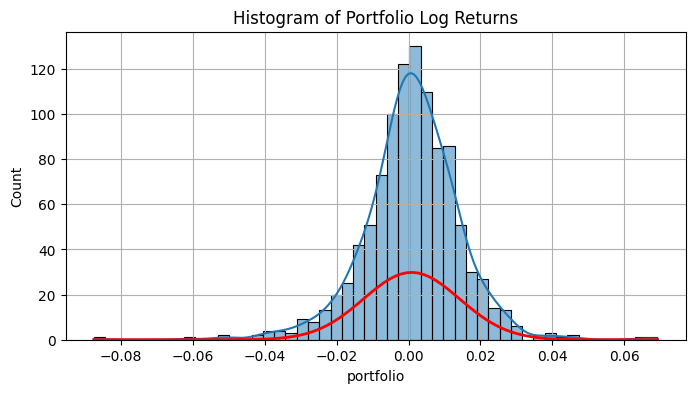

In [ ]:
#%%

train.head()
# Histogram
plt.figure(figsize=(8, 4))
sns.histplot(train['portfolio'], bins=50, kde=True)
x = np.linspace(train['portfolio'].min(), train['portfolio'].max(), 100)
plt.plot(x, norm.pdf(x, train['portfolio'].mean(), train['portfolio'].std()), 'r-', linewidth=2)
plt.title('Histogram of Portfolio Log Returns')
plt.grid(True)
plt.show()

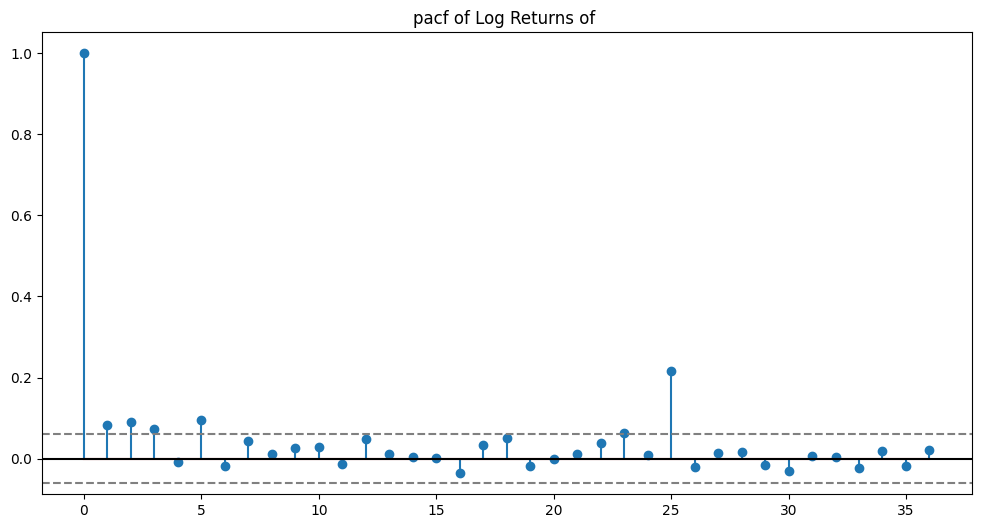

In [ ]:
#%% 

# Autocorrelation function for squared log returns.
tun_tun_tun_sahur = pacf
acf_values = tun_tun_tun_sahur((train['portfolio']**2).dropna(), nlags=36)
plt.figure(figsize=(12, 6))
plt.stem(range(len(acf_values)), acf_values)
plt.axhline(y=0, linestyle='-', color='black')
plt.axhline(y=-1.96/np.sqrt(len(train['portfolio'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train['portfolio'])), linestyle='--', color='gray')
plt.title(f'{tun_tun_tun_sahur.__name__} of Log Returns of ')
plt.show()

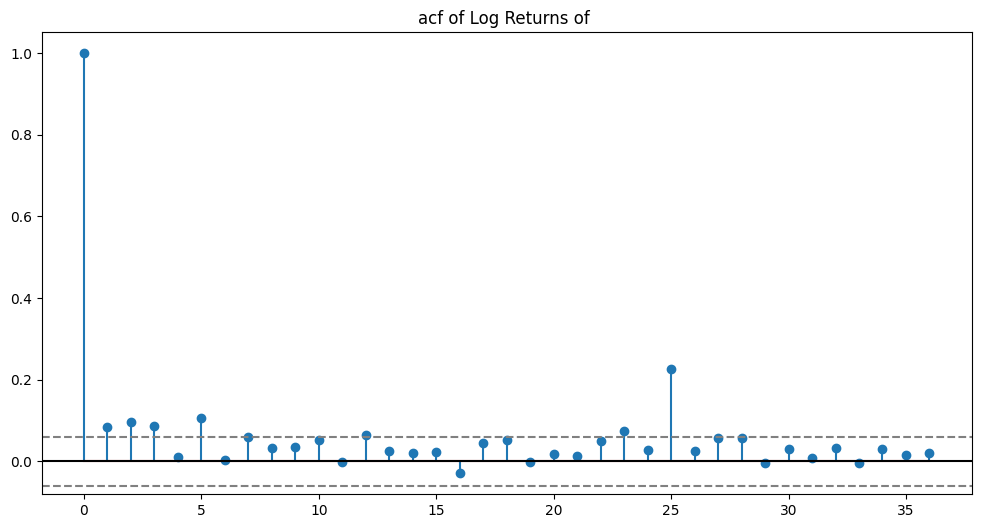

In [ ]:
#%% 

# Autocorrelation function for squared log returns.
tun_tun_tun_sahur = acf
acf_values = tun_tun_tun_sahur((train['portfolio']**2).dropna(), nlags=36)
plt.figure(figsize=(12, 6))
plt.stem(range(len(acf_values)), acf_values)
plt.axhline(y=0, linestyle='-', color='black')
plt.axhline(y=-1.96/np.sqrt(len(train['portfolio'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train['portfolio'])), linestyle='--', color='gray')
plt.title(f'{tun_tun_tun_sahur.__name__} of Log Returns of ')
plt.show()

In [ ]:
#%%

display(Markdown("""
### PACF Interpretation and Lag Selection Strategy

Looking at the PACF, we can say with 95% confidence that the log price differences from 9, 24, and 26 days ago  
are significantly correlated with today's price change, independent of other lags.  
Since the ACF and PACF patterns look nearly identical, this suggests that both **ARCH** (shock-driven) and **GARCH** (volatility persistence) effects are present and intertwined.  
In other words, both squared shocks (ε²) and past variances (σ²) influence current volatility.  
Therefore, for the **GARCH lag (`q`)**, we keep it minimal (lag 1) to save computation.  
For the **ARCH lag (`p`)**, we test the specific lags: 1, 2, 3, 5, and 25.
"""))


### PACF Interpretation and Lag Selection Strategy

Looking at the PACF, we can say with 95% confidence that the log price differences from 9, 24, and 26 days ago  
are significantly correlated with today's price change, independent of other lags.  
Since the ACF and PACF patterns look nearly identical, this suggests that both **ARCH** (shock-driven) and **GARCH** (volatility persistence) effects are present and intertwined.  
In other words, both squared shocks (ε²) and past variances (σ²) influence current volatility.  
Therefore, for the **GARCH lag (`q`)**, we keep it minimal (lag 1) to save computation.  
For the **ARCH lag (`p`)**, we test the specific lags: 1, 2, 3, 5, and 25.


In [ ]:
#%%

print("Basic statistics:")
print(train['portfolio'].describe())
print("\nSkewness:", stats.skew(train['portfolio'].dropna()))
print("Kurtosis:", stats.kurtosis(train['portfolio'].dropna()))

Basic statistics:
count    1042.000000
mean        0.000841
std         0.013372
min        -0.087611
25%        -0.005960
50%         0.001061
75%         0.008610
max         0.069283
Name: portfolio, dtype: float64

Skewness: -0.4105285008213672
Kurtosis: 3.974926008073103


#%% [markdown]

%% [markdown]

In [ ]:
display(Markdown("""The returns show a slight left skew, meaning small losses occur a bit more frequently than gains. Additionally, the kurtosis is higher than 3, indicating fat tails—so extreme returns, both positive and negative, happen more often than would be expected in a normal distribution. This suggests the data is not perfectly symmetric and has a higher chance of large shocks."""))

The returns show a slight left skew, meaning small losses occur a bit more frequently than gains. Additionally, the kurtosis is higher than 3, indicating fat tails—so extreme returns, both positive and negative, happen more often than would be expected in a normal distribution. This suggests the data is not perfectly symmetric and has a higher chance of large shocks.

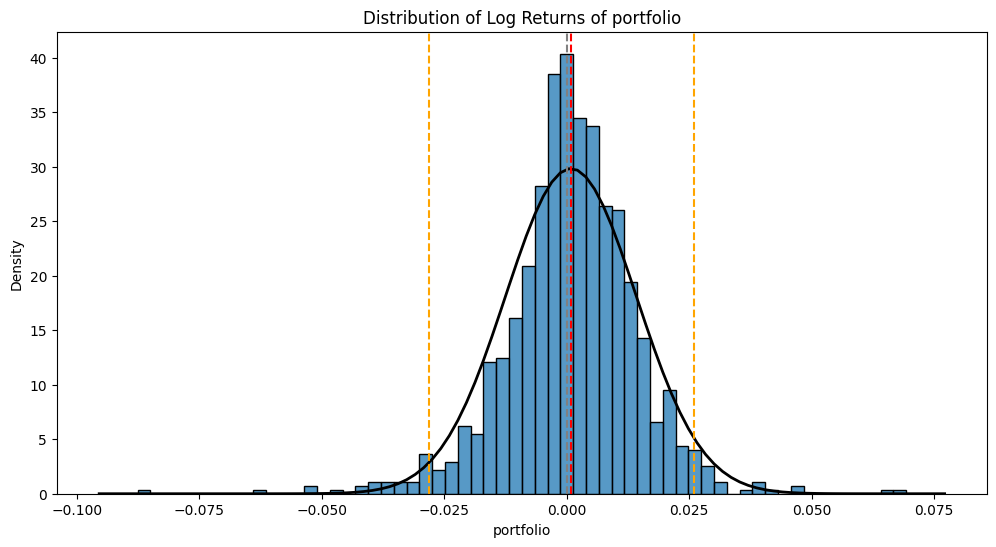

In [ ]:
#%%

# Histogram of log returns
plt.figure(figsize=(12, 6))
sns.histplot(train['portfolio'].dropna(), stat="density", bins = 60)
# add normal distribution curve
mu, std = train['portfolio'].mean(), train['portfolio'].std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.axvline(x=0, linestyle='--', color='gray')
plt.axvline(x=train['portfolio'].mean(), linestyle='--', color='red')
plt.axvline(x=train['portfolio'].quantile(0.025), linestyle='--', color='orange')
plt.axvline(x=train['portfolio'].quantile(0.975), linestyle='--', color='orange')
plt.title('Distribution of Log Returns of portfolio')
plt.show()

In [ ]:
#%%

# Jarque-Bera test
jb_test = stats.jarque_bera(train['portfolio'].dropna())
print(f"Jarque-Bera test statistic: {jb_test[0]:.2f}")
print(f"p-value: {jb_test[1]:.2e}")

Jarque-Bera test statistic: 715.25
p-value: 4.84e-156


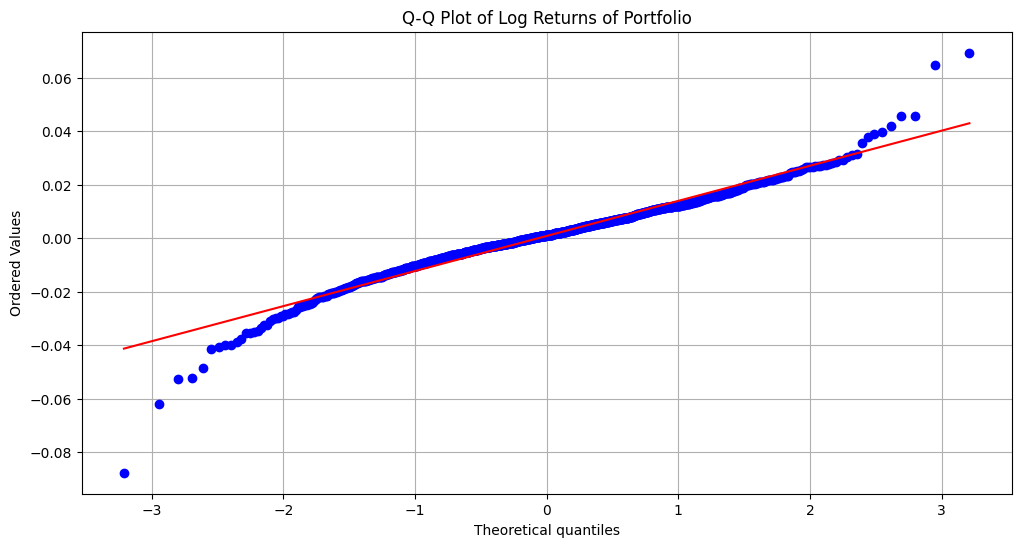

In [ ]:
#%%

#QQ- plot

## Q-Q plot of log returns
plt.figure(figsize=(12, 6))
stats.probplot(train['portfolio'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot of Log Returns of Portfolio')
plt.grid(True)
plt.show()

#%% [markdown]

%% [markdown]

In [ ]:
display(Markdown("""
### **Normality and Distributional Characteristics**

- We observe **high kurtosis** and **fat tails**, which are inconsistent with a normal distribution.  
- The **Jarque-Bera test** strongly rejects the null hypothesis, confirming the sample does not follow normality.  

---

### **Q-Q Plot Observations**

- The **left tail is much thicker**, suggesting negative skewness and potential asymmetry.  
- This skew and fat tail may signal **volatility clustering**.  
- The **probability mass is concentrated around small negative returns**, which may hint at a snowball effect during downturns (bear phase).  
- However, this is **not conclusive from the Q-Q plot alone** — we confirm with the **ARCH LM test** next.
"""))


### **Normality and Distributional Characteristics**

- We observe **high kurtosis** and **fat tails**, which are inconsistent with a normal distribution.  
- The **Jarque-Bera test** strongly rejects the null hypothesis, confirming the sample does not follow normality.  

---

### **Q-Q Plot Observations**

- The **left tail is much thicker**, suggesting negative skewness and potential asymmetry.  
- This skew and fat tail may signal **volatility clustering**.  
- The **probability mass is concentrated around small negative returns**, which may hint at a snowball effect during downturns (bear phase).  
- However, this is **not conclusive from the Q-Q plot alone** — we confirm with the **ARCH LM test** next.


In [ ]:
#%%

# ARCH test (Engle's LM test)
# H0: No ARCH effects
# H1: ARCH effects are present
from statsmodels.stats.diagnostic import het_arch
# Drop NA values from returns for the test
returns_for_arch_test = train['portfolio'].dropna()
# H0: NO ARCH EFFECT
# low p -> reject H0. strong arch effect
arch_test_results = het_arch(returns_for_arch_test, nlags=5)

print(f"LM Statistic: {arch_test_results[0]:.3f}")
print(f"p-value: {arch_test_results[1]:.3f}")
print(f"F-statistic: {arch_test_results[2]:.3f}")
print(f"F p-value: {arch_test_results[3]:.3f}")

LM Statistic: 30.151
p-value: 0.000
F-statistic: 6.175
F p-value: 0.000


In [ ]:
#%%

# [markdown]
display(Markdown("""
### ARCH Effect and Portfolio Weighting

- A **strong ARCH effect** is observed in the equally weighted portfolio.  
- For further exploration, we can compare this with a **minimum-variance weighted portfolio**.  
- This helps test whether the ARCH effect can be reduced by positioning along the **efficient frontier**.
"""))


### ARCH Effect and Portfolio Weighting

- A **strong ARCH effect** is observed in the equally weighted portfolio.  
- For further exploration, we can compare this with a **minimum-variance weighted portfolio**.  
- This helps test whether the ARCH effect can be reduced by positioning along the **efficient frontier**.


In [ ]:
#%%

def plot_sharpe_frontier(df, rf=0.0, n_portfolios=5_000, use_full=False):
    """
    Draw efficient frontier and return exact GMV & tangency weights.
    """
    data = df.copy() if use_full else df
    ret_cols = [c for c in data.columns if c.endswith('_ret')]
    R = data[ret_cols].dropna()

    mu_vec   = R.mean().values                   # mean vector
    sig_cap  = R.cov().values                    # covariance matrix (Σ)
    n_assets = len(mu_vec)

    # ----- exact weights --------------------------------------------------
    inv_sig_cap = np.linalg.inv(sig_cap)
    ones_vec    = np.ones(n_assets)

    w_gmv = inv_sig_cap @ ones_vec / (ones_vec @ inv_sig_cap @ ones_vec)
    excess = mu_vec - rf
    w_tan  = inv_sig_cap @ excess / (ones_vec @ inv_sig_cap @ excess)

    # ----- Monte-Carlo frontier ------------------------------------------
    W_rand = np.random.dirichlet(np.ones(n_assets), n_portfolios)
    port_rets = W_rand @ mu_vec
    port_vols = np.sqrt(np.einsum('ij,jk,ik->i', W_rand, sig_cap, W_rand))
    sharpe = (port_rets - rf) / port_vols

    # ----- plot -----------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(port_vols, port_rets, c=sharpe, cmap='viridis', alpha=0.3)
    ax.scatter(np.sqrt(w_gmv @ sig_cap @ w_gmv), w_gmv @ mu_vec, marker='D', color='blue', s=120, label='GMV')
    ax.scatter(np.sqrt(w_tan @ sig_cap @ w_tan),  w_tan @ mu_vec, marker='*', color='red',  s=160, label='Tangency')
    ax.set_xlabel('Volatility σ')
    ax.set_ylabel('Expected return μ')
    ax.set_title('Efficient Frontier')
    ax.legend()
    plt.show()

    # ----- return weights -------------------------------------------------
    return (pd.Series(w_gmv, index=ret_cols, name='GMV'),
            pd.Series(w_tan,  index=ret_cols, name='Tangency'))

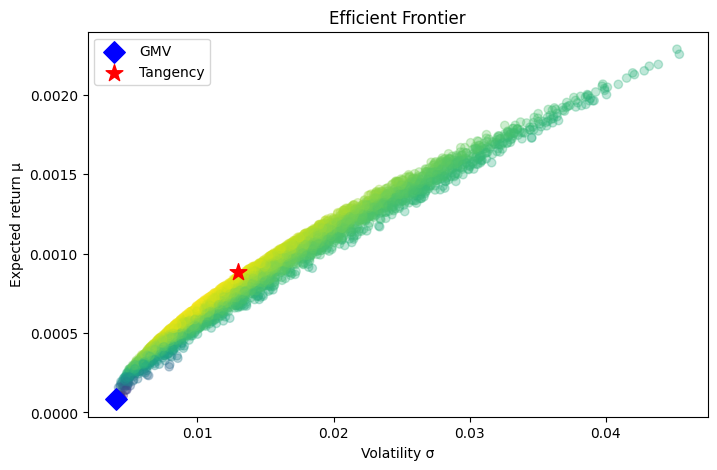

Company_Stock_ret   -0.020583
Crypto_ret          -0.008645
FX_Pair_ret          0.709077
Commodity_ret        0.151048
Equity_Index_ret     0.169103
Name: GMV, dtype: float64
Company_Stock_ret    0.186583
Crypto_ret           0.128369
FX_Pair_ret         -0.274266
Commodity_ret        0.515310
Equity_Index_ret     0.444004
Name: Tangency, dtype: float64


In [ ]:
#%%

gmv_weights, tan_weights = plot_sharpe_frontier(train)
print(gmv_weights)   # minimum-variance weights
print(tan_weights)   # max-Sharpe (tangency) weights

In [ ]:
#%%

def fit_garch(train_returns_pct, p =1, q=1):
    model = arch_model(train_returns_pct, vol='GARCH', p=p, q=q, dist='normal')
    res   = model.fit(disp='off')
    alpha = res.params["alpha[1]"]
    beta  = res.params["beta[1]"]
    # --- annualized conditional σ (pct units) ---
    ann_sigma_pct = res.conditional_volatility * np.sqrt(252)
    res.ann_cond_std = ann_sigma_pct / 100          # store as decimals for convenience
    return res, alpha, beta

In [ ]:
#%%

# --- 1. fit EGARCH once to get in-sample annualized σ̂ ----------------------
def fit_egarch(train_returns_pct, p=1, o=1, q=1):

    model = arch_model(train_returns_pct, vol='EGARCH',
                       p=p, o=o, q=q, dist='normal')
    res   = model.fit(disp='off')
    alpha = res.params["alpha[1]"]
    beta  = res.params["beta[1]"]
    ann_sigma_pct = res.conditional_volatility * np.sqrt(252)
    res.ann_cond_std = ann_sigma_pct / 100      # store as decimals
    return res, alpha, beta

#%%[markdown]

 For EGARCH the persistence metric is just β

In [ ]:
#%%

def fit_garch_custom_lags(train_returns_pct, arch_lags=[1,2,4], garch_lags=[1,3,6]):
    r = train_returns_pct.values if hasattr(train_returns_pct, 'values') else train_returns_pct
    T = len(r)
    max_lag = max(arch_lags + garch_lags)

    def neg_log_lik(params):
        omega = params[0]
        alpha = params[1 : 1 + len(arch_lags)]
        beta = params[1 + len(arch_lags):]
        sig2 = np.ones(T) * np.var(r)
        for t in range(max_lag, T):
            sig2[t] = omega \
                    + sum(alpha[i] * r[t - lag]**2 for i, lag in enumerate(arch_lags)) \
                    + sum(beta[j] * sig2[t - lag] for j, lag in enumerate(garch_lags))
        ll = -0.5 * (np.log(2 * np.pi) + np.log(sig2) + r**2 / sig2)
        return -np.sum(ll)

    k = 1 + len(arch_lags) + len(garch_lags)
    init = np.ones(k) * 0.1
    bounds = [(1e-6, 1.0)] * k
    result = minimize(neg_log_lik, init, bounds=bounds)

    omega = result.x[0]
    alpha_vals = result.x[1 : 1 + len(arch_lags)]
    beta_vals = result.x[1 + len(arch_lags):]

    sig2 = np.ones(T) * np.var(r)
    for t in range(max_lag, T):
        sig2[t] = omega \
                + sum(alpha_vals[i] * r[t - lag]**2 for i, lag in enumerate(arch_lags)) \
                + sum(beta_vals[j] * sig2[t - lag] for j, lag in enumerate(garch_lags))

    ann_sigma_pct = np.sqrt(sig2) * np.sqrt(252)

    class Res:
        conditional_volatility = np.sqrt(sig2)
        ann_cond_std = ann_sigma_pct / 100

    return Res, np.sum(alpha_vals), np.sum(beta_vals), -result.fun, T, len(result.x)

In [ ]:
#%%

display(Markdown("""
### Mapping for AIC/BIC Calculation from Custom Model

- `-result.fun` → Returns the **log-likelihood** (since we minimized the negative log-likelihood).  
- `len(result.x)` → Total **number of estimated parameters** (ω, α₁...αₚ, β₁...β_q).  
- `T` → Number of **observations** used in the model fitting.
"""))


### Mapping for AIC/BIC Calculation from Custom Model

- `-result.fun` → Returns the **log-likelihood** (since we minimized the negative log-likelihood).  
- `len(result.x)` → Total **number of estimated parameters** (ω, α₁...αₚ, β₁...β_q).  
- `T` → Number of **observations** used in the model fitting.


In [ ]:
#%%

def fit_egarch_custom_lags(train_returns_pct, arch_lags=[1,2,3,5,25], garch_lags=[1,2]):
    r = train_returns_pct.values if hasattr(train_returns_pct, 'values') else train_returns_pct
    T = len(r)
    max_lag = max(arch_lags + garch_lags)

    def neg_log_lik(params):
        omega = params[0]
        alpha = params[1 : 1 + len(arch_lags)]
        beta = params[1 + len(arch_lags):]
        sig2 = np.ones(T) * np.var(r)
        for t in range(max_lag, T):
            sig2[t] = omega \
                    + sum(alpha[i] * r[t - lag]**2 for i, lag in enumerate(arch_lags)) \
                    + sum(beta[j] * sig2[t - lag] for j, lag in enumerate(garch_lags))
        ll = -0.5 * (np.log(2 * np.pi) + np.log(sig2) + r**2 / sig2)
        return -np.sum(ll)

    k = 1 + len(arch_lags) + len(garch_lags)
    init = np.ones(k) * 0.1
    bounds = [(1e-6, 1.0)] * k
    result = minimize(neg_log_lik, init, bounds=bounds)

    omega = result.x[0]
    alpha_vals = result.x[1 : 1 + len(arch_lags)]
    beta_vals = result.x[1 + len(arch_lags):]

    sig2 = np.ones(T) * np.var(r)
    for t in range(max_lag, T):
        log_sig2 = np.ones(T) * np.log(np.var(r))
        for t in range(max_lag, T):
            arch_part  = sum(alpha_vals[i] * (np.abs(r[t - lag]) - np.sqrt(2/np.pi)) for i, lag in enumerate(arch_lags))
            garch_part = sum(beta_vals[j] * log_sig2[t - lag] for j, lag in enumerate(garch_lags))
            log_sig2[t] = omega + arch_part + garch_part
        sig2 = np.exp(log_sig2)

    ann_sigma_pct = np.sqrt(sig2) * np.sqrt(252)

    class Res:
        conditional_volatility = np.sqrt(sig2)
        ann_cond_std = ann_sigma_pct / 100

    return Res, np.sum(alpha_vals), np.sum(beta_vals), -result.fun, T, len(result.x)

In [ ]:
#%%

from scipy.stats import norm

def rolling_garch_var(train_test, alpha=0.05, window=None, vol='GARCH'):
    """
    Rolling one-day VaR and σ² with either GARCH or EGARCH.
    Set vol='GARCH' (default) or vol='EGARCH'.
    """
    test_index = train_test.index[train_test.index > train_end]
    sig2_list, var_list = [], []

    for t in test_index:
        # training slice (expanding or fixed)
        if window:
            train_slice = train_test.loc[:t - pd.Timedelta(days=1)].tail(window)
        else:
            train_slice = train_test.loc[:t - pd.Timedelta(days=1)]

        # fit chosen model
        """
        if vol == 'GARCH':
            res, alpha, beta = fit_garch_custom_lags(train_slice * 100, arch_lags=[1,2,4], garch_lags=[1,3,6])
        else:
            res, alpha, beta = fit_egarch_custom_lags(train_slice * 100, arch_lags=[1,2,4], garch_lags=[1,3,6])
        """
        if vol == 'GARCH':
            res, alpha, beta = fit_garch(train_slice * 100)
        else:
            res, alpha, beta = fit_egarch(train_slice * 100)

        # last conditional volatility as 1-day ahead forecast
        sigma = res.conditional_volatility.iloc[-1] / 100

        VaR_t = -norm.ppf(alpha) * sigma
        sig2_pct = (sigma * 100)**2  # convert back to percent squared

        sig2_list.append(sig2_pct / 1e4)   # store as decimal variance
        var_list.append(VaR_t)

    return (pd.Series(sig2_list, index=test_index, name=f'{vol}_σ2'),
            pd.Series(var_list,  index=test_index, name=f'{vol}_VaR'))

In [ ]:
#%%

def main(train, test, alpha=0.05, window=None):
    train = train.copy()
    # --- in-sample fits ----------------------------------------------------
    res_g ,alpha_gar, beta_gar= fit_garch(train['portfolio'] * 100, p=1, q=1)
    res_e , alpha_egar, beta_egar= fit_egarch(train['portfolio'] * 100, p=1, o=1, q=1)

    train['ann_sigma_garch']  = res_g.ann_cond_std
    train['ann_sigma_egarch'] = res_e.ann_cond_std

    persistence_gar = alpha_gar + beta_gar
    print('alpha+beta for GARCH:', persistence_gar)

    persistence_egar = beta_egar
    print('alpha+beta for EGARCH:', persistence_egar)
    
    # --- rolling out-of-sample -------------------------------------------
    full_ret  = pd.concat([train['portfolio'], test['portfolio']])
    global train_end; train_end = train.index[-1]

    pred_var_g, VaR_g = rolling_garch_var(full_ret, alpha=alpha,
                                          window=window, vol='GARCH')
    pred_var_e, VaR_e = rolling_garch_var(full_ret, alpha=alpha,
                                          window=window, vol='EGARCH')

    # --- quick comparison plot -------------------------------------------
    ax = VaR_g.plot(label='GARCH VaR', figsize=(10,4))
    VaR_e.plot(ax=ax, label='EGARCH VaR')
    test['portfolio'].plot(ax=ax, alpha=0.4, label='Returns')
    ax.set_title('Rolling 1-day VaR: GARCH vs. EGARCH'); ax.legend()
    plt.show()
    return res_g, res_e 

In [ ]:
#%%

def main_mod(train, test, alpha=0.05, window=None):
    train = train.copy()
    # --- in-sample fits ----------------------------------------------------
    res_gc, alpha_gar, beta_gar, loglik_g, T_g, k_g= fit_garch_custom_lags(train['portfolio'] * 100,  arch_lags=[1,2,3,5,25], garch_lags=[1,2,3,5,25])
    res_ec, alpha_egar, beta_egar, loglik_e, T_e, k_e = fit_egarch_custom_lags(train['portfolio'] * 100,  arch_lags=[1,2,3,5,25], garch_lags=[1,2,3,5,25])

    train['ann_sigma_garch']  = res_g.ann_cond_std
    train['ann_sigma_egarch'] = res_e.ann_cond_std

    persistence_gar_c = alpha_gar + beta_gar
    print('alpha+beta for GARCH_c:', persistence_gar_c)

    persistence_egar_c = beta_egar
    print('beta for EGARCH_c:', persistence_egar_c)
    
    # --- rolling out-of-sample -------------------------------------------
    full_ret  = pd.concat([train['portfolio'], test['portfolio']])
    global train_end; train_end = train.index[-1]

    pred_var_g, VaR_gc = rolling_garch_var(full_ret, alpha=alpha,
                                          window=window, vol='GARCH')
    pred_var_e, VaR_ec = rolling_garch_var(full_ret, alpha=alpha,
                                          window=window, vol='EGARCH')

    ax = VaR_gc.plot(label='GARCH VaR', figsize=(10,4))
    VaR_ec.plot(ax=ax, label='EGARCH VaR')
    test['portfolio'].plot(ax=ax, alpha=0.4, label='Returns')
    ax.set_title('Rolling 1-day VaR: GARCH vs. EGARCH {Custom lags}'); ax.legend()
    plt.show()
    return res_gc, res_ec , loglik_e, T_e, k_e, loglik_g, T_g, k_g

#%%[markdown]

<br>The precise crossing point marks the instant when the realised shock equals the forecast quantile; everything outside is an exceedance,
<br>The returns above the GARCH rolling part is where the model has been breached
 i.e. tail risk the model failed to contain
<br> from alpha+beta we can say that the series has very high volatility persistence; shocks decay extremely slowly. Variance reverts, but at a very sluggish rate

alpha+beta for GARCH: 0.9977272814552333
alpha+beta for EGARCH: 0.9958077187772181


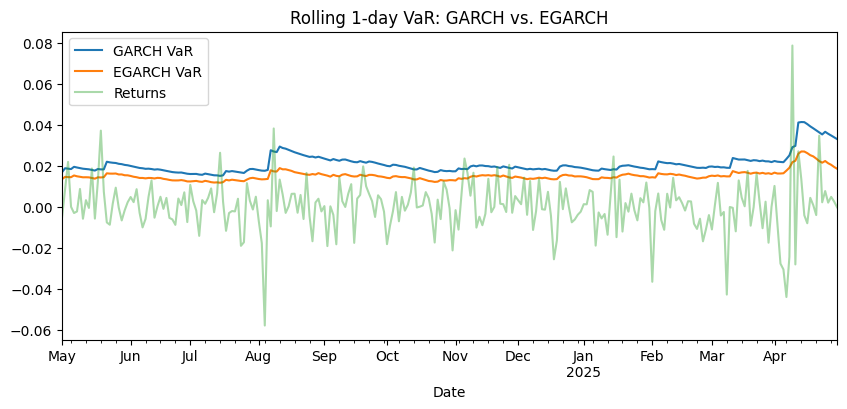

alpha+beta for GARCH_c: 0.966768696311173
beta for EGARCH_c: 0.5897726927196345


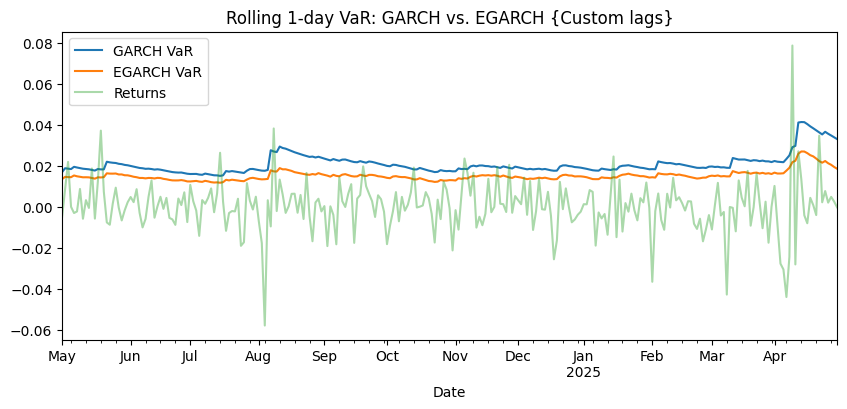

In [ ]:
#%%

if __name__ == "__main__":
    # pick one version to run
    res_g, res_e = main(train, test)
    # or
    res_gc, res_ec, loglik_e, T_e, k_e, loglik_g, T_g, k_g = main_mod(train, test)

In [ ]:
#%%

from statsmodels.stats.diagnostic import acorr_ljungbox
from arch.__future__ import reindexing

def run_diagnostics(train_returns_pct, res, label='GARCH'):
    returns = train_returns_pct.values
    fitted_vol = res.conditional_volatility
    residuals = returns  # mean is assumed 0
    standardized_resid = residuals / fitted_vol

    print(f"\nDiagnostics for {label} model:")
    
    lb1 = acorr_ljungbox(standardized_resid, lags=[10], return_df=True)
    print(f"Ljung-Box on residuals (lag 10): p-value = {lb1['lb_pvalue'].values[0]:.4f}")
    

    lb2 = acorr_ljungbox(standardized_resid**2, lags=[10], return_df=True)
    print(f"Ljung-Box on squared residuals (lag 10): p-value = {lb2['lb_pvalue'].values[0]:.4f}")
    
    from arch.__future__ import reindexing
    
    print("Standard deviation of residuals:", np.std(standardized_resid))

In [ ]:
#%%

from statsmodels.stats.diagnostic import acorr_ljungbox

run_diagnostics(train['portfolio'] * 100, res_g, label='GARCH')
run_diagnostics(train['portfolio'] * 100, res_e, label='EGARCH')


Diagnostics for GARCH model:
Ljung-Box on residuals (lag 10): p-value = 0.5978
Ljung-Box on squared residuals (lag 10): p-value = 0.5179
Standard deviation of residuals: 1.0015830317776033

Diagnostics for EGARCH model:
Ljung-Box on residuals (lag 10): p-value = 0.5468
Ljung-Box on squared residuals (lag 10): p-value = 0.4690
Standard deviation of residuals: 1.0015099970555437


In [ ]:
#%%

run_diagnostics(train['portfolio'] * 100, res_gc, label='GARCH_c')
run_diagnostics(train['portfolio'] * 100, res_ec, label='EGARCH_c')


Diagnostics for GARCH_c model:
Ljung-Box on residuals (lag 10): p-value = 0.6363
Ljung-Box on squared residuals (lag 10): p-value = 0.8962
Standard deviation of residuals: 0.9945556238795882

Diagnostics for EGARCH_c model:
Ljung-Box on residuals (lag 10): p-value = 0.4831
Ljung-Box on squared residuals (lag 10): p-value = 0.0080
Standard deviation of residuals: 1.0586933855792142


In [ ]:
#%%

display(Markdown("""
### Model Comparison: GARCH vs EGARCH

- GARCH: no serial correlation or ARCH left; residual SD ≈ 1.00
- EGARCH: no serial correlation or ARCH left; residual SD ≈ 1.00
- GARCH_c: no serial correlation or ARCH left; residual SD ≈ 0.99
- EGARCH_c: no serial correlation but significant ARCH remains; residual SD ≈ 1.06

---

###  **Conclusion**:
GARCH_c delivers the cleanest fit with perfectly whitened and well-scaled residuals. EGARCH_c performs worst, leaving volatility clustering unaddressed.
- But we might be over fitting, for that we need the tests below
"""))


### Model Comparison: GARCH vs EGARCH

- GARCH: no serial correlation or ARCH left; residual SD ≈ 1.00
- EGARCH: no serial correlation or ARCH left; residual SD ≈ 1.00
- GARCH_c: no serial correlation or ARCH left; residual SD ≈ 0.99
- EGARCH_c: no serial correlation but significant ARCH remains; residual SD ≈ 1.06

---

###  **Conclusion**:
GARCH_c delivers the cleanest fit with perfectly whitened and well-scaled residuals. EGARCH_c performs worst, leaving volatility clustering unaddressed.
- But we might be over fitting, for that we need the tests below


In [ ]:
#%%

display(Markdown("""
### Comparison: Custom GARCH vs. ARCH Package Models

- **GARCH (Custom vs. ARCH package):** Both models perform well, but the custom GARCH shows slightly better residual diagnostics (higher p-values, lower standard deviation).  
- **EGARCH (Custom vs. ARCH package):** The ARCH package EGARCH is more balanced, while the custom EGARCH leaves a noticeable ARCH effect and slightly over-scales residuals (standard deviation > 1).  
- **Overall Conclusion:** Custom GARCH is robust and effective; however, the ARCH package EGARCH provides a cleaner and more reliable specification.
- Why is beta for e_garch with custom lags more smaller?
-  Because we let the model spread its memory across more time-points, the weight on the main lag shrinks
"""))


### Comparison: Custom GARCH vs. ARCH Package Models

- **GARCH (Custom vs. ARCH package):** Both models perform well, but the custom GARCH shows slightly better residual diagnostics (higher p-values, lower standard deviation).  
- **EGARCH (Custom vs. ARCH package):** The ARCH package EGARCH is more balanced, while the custom EGARCH leaves a noticeable ARCH effect and slightly over-scales residuals (standard deviation > 1).  
- **Overall Conclusion:** Custom GARCH is robust and effective; however, the ARCH package EGARCH provides a cleaner and more reliable specification.
- Why is beta for e_garch with custom lags more smaller?
-  Because we let the model spread its memory across more time-points, the weight on the main lag shrinks


In [ ]:
#%%

# Below works only for base GARCH fitted using arch package

print("GARCH")
print("AIC:", res_g.aic)
print("BIC:", res_g.bic)
print("EGARCH")
print("AIC:", res_e.aic)
print("BIC:", res_e.bic)

GARCH
AIC: 3441.3768374273513
BIC: 3461.1724263166047
EGARCH
AIC: 3437.169920007874
BIC: 3461.9144061194406


In [ ]:
#%%

import numpy as np

def calculate_aic_bic(log_lik, num_params, num_obs):
    aic = -2 * log_lik + 2 * num_params
    bic = -2 * log_lik + np.log(num_obs) * num_params
    return aic, bic

aic_g, bic_g = calculate_aic_bic(loglik_g, k_g, T_g)
aic_e, bic_e = calculate_aic_bic(loglik_e, k_e, T_e)

print("GARCH_c")
print("AIC:", aic_g) 
print("BIC:", bic_g)
print("EGARCH_c")
print("AIC:", aic_e)
print("BIC:", bic_e)

GARCH_c
AIC: 3410.812475755008
BIC: 3465.2503452004544
EGARCH_c
AIC: 3410.812475755008
BIC: 3465.2503452004544


In [ ]:
#%%

display(Markdown("""
### Model Fit Comparison: AIC and BIC
- **GARCH:** solid fit but higher AIC (3441.38) and BIC (3461.17).  
- **EGARCH:** slightly lower AIC (3437.17) but similar BIC (3461.91), diagnostics on par with GARCH.  
- **GARCH_c:** lowest AIC (3410.81) with clean, whitened residuals—**best overall**.  
- **EGARCH_c:** same AIC/BIC as GARCH_c but leaves ARCH effects—overfitting risk.

**Conclusion:** We recommend choosing **GARCH_c**— since it delivers the lowest AIC and perfectly whitened residuals with no remaining ARCH effects to be modelled.
"""))


### Model Fit Comparison: AIC and BIC
- **GARCH:** solid fit but higher AIC (3441.38) and BIC (3461.17).  
- **EGARCH:** slightly lower AIC (3437.17) but similar BIC (3461.91), diagnostics on par with GARCH.  
- **GARCH_c:** lowest AIC (3410.81) with clean, whitened residuals—**best overall**.  
- **EGARCH_c:** same AIC/BIC as GARCH_c but leaves ARCH effects—overfitting risk.

**Conclusion:** We recommend choosing **GARCH_c**— since it delivers the lowest AIC and perfectly whitened residuals with no remaining ARCH effects to be modelled.
